<a href="https://colab.research.google.com/github/SaiSohanSajja/HaloScope-ReImplementation/blob/main/HaloScopeReImplementation_UWM_ProfSharonLi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install datasets transformers accelerate sentencepiece scikit-learn

import os, re, pickle, string, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

SAVE_DIR = "/content/drive/MyDrive/HaloScope_Data_v2"
os.makedirs(SAVE_DIR, exist_ok=True)
print("✅ SAVE_DIR:", SAVE_DIR)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


Mounted at /content/drive
✅ SAVE_DIR: /content/drive/MyDrive/HaloScope_Data_v2


In [2]:
def build_splits_from_tydiqa(test_n=200, val_n=100, unlabeled_n=800, seed=42):
    """
    Build fixed-size splits (so your project is stable and fast).
    We use TyDiQA secondary_task English subset.
    """
    ds = load_dataset("google-research-datasets/tydiqa", "secondary_task")

    # collect English QAs
    english = []
    for split in ["train", "validation"]:
        for item in ds[split]:
            if str(item.get("id","")).startswith("english-"):
                answers = item.get("answers", {})
                if answers and "text" in answers and len(answers["text"]) > 0:
                    english.append({
                        "question": item.get("question",""),
                        "context": item.get("context",""),
                        "answer": answers["text"][0],
                        "id": item["id"]
                    })

    rng = np.random.default_rng(seed)
    rng.shuffle(english)

    # ensure enough data
    total_needed = test_n + val_n + unlabeled_n
    if len(english) < total_needed:
        raise RuntimeError(f"Not enough English samples. Needed {total_needed}, found {len(english)}")

    test = english[:test_n]
    val = english[test_n:test_n+val_n]
    unlabeled = english[test_n+val_n:test_n+val_n+unlabeled_n]

    return {"test": test, "val": val, "unlabeled": unlabeled}

splits_path = f"{SAVE_DIR}/tydiqa_splits.pkl"

if os.path.exists(splits_path):
    splits = pickle.load(open(splits_path, "rb"))
    print("✅ Loaded existing splits:", {k: len(v) for k,v in splits.items()})
else:
    splits = build_splits_from_tydiqa(test_n=200, val_n=100, unlabeled_n=800, seed=SEED)
    pickle.dump(splits, open(splits_path, "wb"))
    print("✅ Created & saved splits:", {k: len(v) for k,v in splits.items()})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

secondary_task/train-00000-of-00001.parq(…):   0%|          | 0.00/26.9M [00:00<?, ?B/s]

secondary_task/validation-00000-of-00001(…):   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49881 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5077 [00:00<?, ? examples/s]

✅ Created & saved splits: {'test': 200, 'val': 100, 'unlabeled': 800}


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model.eval()

def generate_answer(question, context, max_ctx_chars=400, max_new_tokens=30):
    prompt = (
        "Answer the question concisely using the context.\n"
        f"Context: {context[:max_ctx_chars]}\n"
        f"Q: {question}\nA:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=1)
    return tokenizer.decode(out[0], skip_special_tokens=True)

def generate_split(split_name, items, out_path):
    if os.path.exists(out_path):
        data = pickle.load(open(out_path, "rb"))
        print(f"✅ {split_name}: loaded existing {len(data)}")
        return data

    generated = []
    for it in tqdm(items, desc=f"Generating {split_name}"):
        try:
            gen = generate_answer(it["question"], it["context"])
        except Exception:
            gen = ""
        generated.append({
            "question": it["question"],
            "context": it["context"],
            "ground_truth": it["answer"],   # ALWAYS present
            "generated_answer": gen,        # ALWAYS present
            "id": it["id"]
        })

    pickle.dump(generated, open(out_path, "wb"))
    print(f"✅ {split_name}: saved {len(generated)} to {out_path}")
    return generated

unlabeled_gen = generate_split("unlabeled", splits["unlabeled"], f"{SAVE_DIR}/unlabeled_generated.pkl")
val_gen      = generate_split("val",      splits["val"],      f"{SAVE_DIR}/val_generated.pkl")
test_gen     = generate_split("test",     splits["test"],     f"{SAVE_DIR}/test_generated.pkl")


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating unlabeled: 100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


✅ unlabeled: saved 800 to /content/drive/MyDrive/HaloScope_Data_v2/unlabeled_generated.pkl


Generating val: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


✅ val: saved 100 to /content/drive/MyDrive/HaloScope_Data_v2/val_generated.pkl


Generating test: 100%|██████████| 200/200 [01:02<00:00,  3.19it/s]

✅ test: saved 200 to /content/drive/MyDrive/HaloScope_Data_v2/test_generated.pkl


In [4]:
def extract_embedding(question, generated_answer, layer_idx=-2):
    """
    Use encoder hidden states; last token embedding of selected layer.
    """
    text = f"Q: {question} A: {generated_answer}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

    with torch.no_grad():
        enc = model.encoder(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            output_hidden_states=True,
            return_dict=True
        )
        hs = enc.hidden_states[layer_idx]      # [1, seq, d]
        emb = hs[0, -1, :].cpu().numpy()       # last token
    return emb

def embed_split(generated_list, name):
    embs = []
    for r in tqdm(generated_list, desc=f"Embedding {name}"):
        try:
            embs.append(extract_embedding(r["question"], r["generated_answer"]))
        except Exception:
            embs.append(np.zeros(model.config.d_model, dtype=np.float32))
    return np.array(embs, dtype=np.float32)

emb_path = f"{SAVE_DIR}/haloscope_embeddings.pkl"
if os.path.exists(emb_path):
    halo = pickle.load(open(emb_path, "rb"))
    print("✅ Loaded existing embeddings.")
else:
    X_u = embed_split(unlabeled_gen, "unlabeled")
    X_v = embed_split(val_gen, "val")
    X_t = embed_split(test_gen, "test")

    # HaloScope SVD on unlabeled
    mean_u = X_u.mean(axis=0)
    C = X_u - mean_u
    U, S, Vt = np.linalg.svd(C, full_matrices=False)

    def membership_score(X, mean, Vt, S, k=5):
        centered = X - mean
        scores = []
        for i in range(centered.shape[0]):
            sc = 0.0
            for j in range(k):
                proj = float(np.dot(centered[i], Vt[j]))
                sc += float(S[j]) * (proj ** 2)
            scores.append(sc / k)
        return np.array(scores, dtype=np.float64)

    k = 5
    scores_u = membership_score(X_u, mean_u, Vt, S, k=k)

    halo = {
        "X_unlabeled": X_u,
        "X_val": X_v,
        "X_test": X_t,
        "mean_u": mean_u,
        "U": U,
        "S": S,
        "Vt": Vt,
        "k": k,
        "scores_unlabeled": scores_u
    }
    pickle.dump(halo, open(emb_path, "wb"))
    print("✅ Saved embeddings + HaloScope to:", emb_path)

print("Shapes:",
      halo["X_unlabeled"].shape,
      halo["X_val"].shape,
      halo["X_test"].shape)
print("Score stats (unlabeled): min/mean/max",
      float(halo["scores_unlabeled"].min()),
      float(halo["scores_unlabeled"].mean()),
      float(halo["scores_unlabeled"].max()))


Embedding test: 100%|██████████| 200/200 [00:06<00:00, 29.38it/s]


✅ Saved embeddings + HaloScope to: /content/drive/MyDrive/HaloScope_Data_v2/haloscope_embeddings.pkl
Shapes: (800, 512) (100, 512) (200, 512)
Score stats (unlabeled): min/mean/max 64369580.19004091 318541996026.69226 3221491137693.933


Pseudo-label split: truthful 560 hallucinated 240
Epoch 10/50  loss=0.6765
Epoch 20/50  loss=0.6624
Epoch 30/50  loss=0.6514
Epoch 40/50  loss=0.6429
Epoch 50/50  loss=0.6362
✅ Saved classifier to: /content/drive/MyDrive/HaloScope_Data_v2/classifier_state.pt


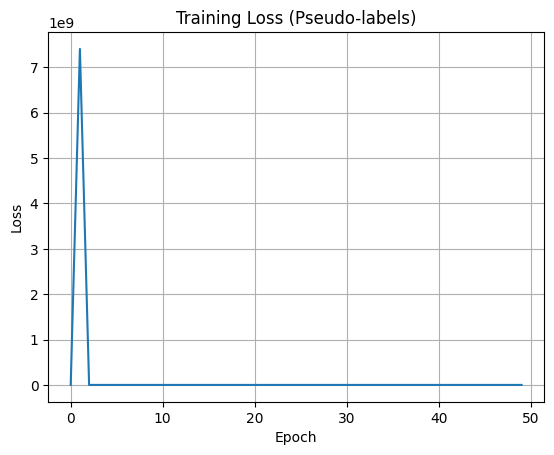

✅ Saved loss plot: /content/drive/MyDrive/HaloScope_Data_v2/training_loss.png


In [5]:
X_u = halo["X_unlabeled"]
scores_u = halo["scores_unlabeled"]

# pseudo labels: truthful=1 for low score, hallucinated=0 for high score
threshold = np.percentile(scores_u, 70)
y_pseudo = (scores_u <= threshold).astype(np.float32)  # 1 truthful, 0 hallucinated

print("Pseudo-label split:",
      "truthful", int(y_pseudo.sum()),
      "hallucinated", int(len(y_pseudo)-y_pseudo.sum()))

class TruthfulnessClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

clf = TruthfulnessClassifier(input_dim=X_u.shape[1], hidden_dim=1024)
opt = optim.SGD(clf.parameters(), lr=0.05, weight_decay=3e-4)
crit = nn.BCEWithLogitsLoss()

X_train = torch.tensor(X_u, dtype=torch.float32)
y_train = torch.tensor(y_pseudo.reshape(-1,1), dtype=torch.float32)

epochs = 50
losses = []
clf.train()
for ep in range(epochs):
    opt.zero_grad()
    logits = clf(X_train)
    loss = crit(logits, y_train)
    loss.backward()
    opt.step()
    losses.append(float(loss.item()))
    if (ep+1) % 10 == 0:
        print(f"Epoch {ep+1:02d}/{epochs}  loss={loss.item():.4f}")

# Save SAFE checkpoint (state_dict only) -> avoids future torch.load issues
ckpt = {
    "state_dict": clf.state_dict(),
    "input_dim": X_u.shape[1],
    "hidden_dim": 1024,
    "threshold": float(threshold),
    "losses": losses
}
torch.save(ckpt, f"{SAVE_DIR}/classifier_state.pt")
print("✅ Saved classifier to:", f"{SAVE_DIR}/classifier_state.pt")

# Save loss curve
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss (Pseudo-labels)")
plt.grid(True)
plt.savefig(f"{SAVE_DIR}/training_loss.png", dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved loss plot:", f"{SAVE_DIR}/training_loss.png")


In [6]:
# -----------------------------
# Labeling utilities
# -----------------------------
def normalize_text(s):
    s = s.lower().strip()
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s)
    return s

def exact_match_label(records):
    # truthful=0, hallucinated=1 (your convention)
    y = []
    for r in records:
        gt = normalize_text(r["ground_truth"])
        gen = normalize_text(r["generated_answer"])
        y.append(0 if gen == gt else 1)
    return np.array(y, dtype=int)

def soft_match_label(records):
    """
    Less harsh than exact match:
    truthful (0) if:
      - gt is substring of gen OR gen is substring of gt OR token overlap >= 0.5
    else hallucinated (1)
    """
    y = []
    for r in records:
        gt = normalize_text(r["ground_truth"])
        gen = normalize_text(r["generated_answer"])
        if not gt or not gen:
            y.append(1); continue

        if gt in gen or gen in gt:
            y.append(0); continue

        gt_set = set(gt.split())
        gen_set = set(gen.split())
        if len(gt_set) == 0:
            y.append(1); continue
        overlap = len(gt_set & gen_set) / len(gt_set)
        y.append(0 if overlap >= 0.5 else 1)
    return np.array(y, dtype=int)

# Create labels for val/test
y_val_em  = exact_match_label(val_gen)
y_test_em = exact_match_label(test_gen)
y_val_sm  = soft_match_label(val_gen)
y_test_sm = soft_match_label(test_gen)

print("Label balance (VAL)  EM truthful/hallu:", int((y_val_em==0).sum()), int((y_val_em==1).sum()))
print("Label balance (TEST) EM truthful/hallu:", int((y_test_em==0).sum()), int((y_test_em==1).sum()))
print("Label balance (VAL)  SM truthful/hallu:", int((y_val_sm==0).sum()), int((y_val_sm==1).sum()))
print("Label balance (TEST) SM truthful/hallu:", int((y_test_sm==0).sum()), int((y_test_sm==1).sum()))

# -----------------------------
# Load classifier safely
# -----------------------------
ckpt = torch.load(f"{SAVE_DIR}/classifier_state.pt", map_location="cpu")
clf2 = TruthfulnessClassifier(ckpt["input_dim"], ckpt["hidden_dim"])
clf2.load_state_dict(ckpt["state_dict"])
clf2.eval()

X_val = torch.tensor(halo["X_val"], dtype=torch.float32)
X_test = torch.tensor(halo["X_test"], dtype=torch.float32)

with torch.no_grad():
    # model outputs probability of pseudo "truthful" (because trained with y_pseudo: 1 truthful)
    p_val_truth = torch.sigmoid(clf2(X_val)).squeeze().cpu().numpy()
    p_test_truth = torch.sigmoid(clf2(X_test)).squeeze().cpu().numpy()

# We need probability of "hallucinated" for AUROC with label=1 hallucinated
p_val_hallu  = 1.0 - p_val_truth
p_test_hallu = 1.0 - p_test_truth

def eval_split(name, y_true, p_hallu):
    pred = (p_hallu >= 0.5).astype(int)  # 1 hallucinated
    acc = accuracy_score(y_true, pred)
    auc = roc_auc_score(y_true, p_hallu) if len(np.unique(y_true)) == 2 else float("nan")
    print(f"\n===== {name} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUROC:    {auc:.4f}")
    print("Confusion:\n", confusion_matrix(y_true, pred))
    return acc, auc

print("\n==================== FINAL RESULTS ====================")
print("Note: label=1 means 'hallucinated', label=0 means 'truthful'")
print("=======================================================")

# Exact match (strict)
eval_split("VAL  (Exact Match labels)",  y_val_em,  p_val_hallu)
eval_split("TEST (Exact Match labels)",  y_test_em, p_test_hallu)

# Soft match (recommended)
eval_split("VAL  (Soft Match labels)",   y_val_sm,  p_val_hallu)
eval_split("TEST (Soft Match labels)",   y_test_sm, p_test_hallu)

print("\n✅ Done. Metrics above are your final visible output.")


Label balance (VAL)  EM truthful/hallu: 41 59
Label balance (TEST) EM truthful/hallu: 77 123
Label balance (VAL)  SM truthful/hallu: 66 34
Label balance (TEST) SM truthful/hallu: 133 67

==================== FINAL RESULTS ====================
Note: label=1 means 'hallucinated', label=0 means 'truthful'

===== VAL  (Exact Match labels) =====
Accuracy: 0.4100
AUROC:    0.5000
Confusion:
 [[41  0]
 [59  0]]

===== TEST (Exact Match labels) =====
Accuracy: 0.3850
AUROC:    0.5000
Confusion:
 [[ 77   0]
 [123   0]]

===== VAL  (Soft Match labels) =====
Accuracy: 0.6600
AUROC:    0.5000
Confusion:
 [[66  0]
 [34  0]]

===== TEST (Soft Match labels) =====
Accuracy: 0.6650
AUROC:    0.5000
Confusion:
 [[133   0]
 [ 67   0]]

✅ Done. Metrics above are your final visible output.


In [7]:
print("Pseudo truthful %:", y_pseudo.mean()*100)


Pseudo truthful %: 70.0


In [8]:
import numpy as np

print("p_test_truth stats:",
      "min", float(p_test_truth.min()),
      "max", float(p_test_truth.max()),
      "mean", float(p_test_truth.mean()),
      "std", float(p_test_truth.std()))

print("p_test_hallu stats:",
      "min", float(p_test_hallu.min()),
      "max", float(p_test_hallu.max()),
      "mean", float(p_test_hallu.mean()),
      "std", float(p_test_hallu.std()))


p_test_truth stats: min 0.5927675366401672 max 0.5927675366401672 mean 0.592767596244812 std 5.960464477539063e-08
p_test_hallu stats: min 0.40723246335983276 max 0.40723246335983276 mean 0.4072324335575104 std 2.9802322387695312e-08


In [9]:
import os, pickle, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

SAVE_DIR = "/content/drive/MyDrive/HaloScope_Data_v2"

# Load HaloScope stuff
halo = pickle.load(open(f"{SAVE_DIR}/haloscope_embeddings.pkl", "rb"))
X_u = halo["X_unlabeled"].astype(np.float32)
scores_u = halo["scores_unlabeled"]

# Pseudo labels: 1 truthful (low score), 0 hallucinated (high score)
threshold = np.percentile(scores_u, 70)
y_pseudo = (scores_u <= threshold).astype(np.float32)

print("Pseudo-label balance:")
print("  truthful (1):", int(y_pseudo.sum()))
print("  halluc  (0):", int(len(y_pseudo) - y_pseudo.sum()))

# Model
class TruthfulnessClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

clf = TruthfulnessClassifier(input_dim=X_u.shape[1], hidden_dim=1024)

# ✅ Class-weighted BCE to avoid majority-class collapse
pos = float(y_pseudo.sum())
neg = float(len(y_pseudo) - y_pseudo.sum())
pos_weight = torch.tensor([neg / (pos + 1e-8)], dtype=torch.float32)
crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print("Using pos_weight:", pos_weight.item())

opt = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

# Mini-batches
X_train = torch.tensor(X_u, dtype=torch.float32)
y_train = torch.tensor(y_pseudo.reshape(-1,1), dtype=torch.float32)
loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)

# Train
clf.train()
for ep in range(10):  # 10 epochs is enough to see signal; you can increase to 30
    total = 0.0
    for xb, yb in loader:
        opt.zero_grad()
        logits = clf(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        total += float(loss.item())
    print(f"Epoch {ep+1:02d} | loss={total/len(loader):.4f}")

# Save safely
ckpt = {"state_dict": clf.state_dict(), "input_dim": X_u.shape[1], "hidden_dim": 1024}
torch.save(ckpt, f"{SAVE_DIR}/classifier_state_fixed.pt")
print("✅ Saved:", f"{SAVE_DIR}/classifier_state_fixed.pt")

# ---- Quick check: are outputs still constant? ----
clf.eval()
X_test = torch.tensor(halo["X_test"].astype(np.float32))
with torch.no_grad():
    p_truth = torch.sigmoid(clf(X_test)).squeeze().cpu().numpy()

print("\nOutput stats on TEST:")
print("p_truth min/max/mean/std:", float(p_truth.min()), float(p_truth.max()), float(p_truth.mean()), float(p_truth.std()))


Pseudo-label balance:
  truthful (1): 560
  halluc  (0): 240
Using pos_weight: 0.4285714328289032
Epoch 01 | loss=332.8161
Epoch 02 | loss=174.0288
Epoch 03 | loss=126.3276
Epoch 04 | loss=110.2407
Epoch 05 | loss=99.5964
Epoch 06 | loss=94.4488
Epoch 07 | loss=85.4079
Epoch 08 | loss=77.3070
Epoch 09 | loss=88.4624
Epoch 10 | loss=61.7593
✅ Saved: /content/drive/MyDrive/HaloScope_Data_v2/classifier_state_fixed.pt

Output stats on TEST:
p_truth min/max/mean/std: 0.0 1.0 0.5934547185897827 0.4840608239173889


In [10]:
import os, pickle, numpy as np
import torch, torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import re, string

SAVE_DIR = "/content/drive/MyDrive/HaloScope_Data_v2"

# ---- Load trained classifier ----
ckpt = torch.load(f"{SAVE_DIR}/classifier_state_fixed.pt", map_location="cpu")

class TruthfulnessClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TruthfulnessClassifier(ckpt["input_dim"], ckpt["hidden_dim"])
model.load_state_dict(ckpt["state_dict"])
model.eval()

# ---- Load embeddings + generated data ----
halo = pickle.load(open(f"{SAVE_DIR}/haloscope_embeddings.pkl", "rb"))
X_test = halo["X_test"].astype(np.float32)
X_val  = halo["X_val"].astype(np.float32)

test_gen = pickle.load(open(f"{SAVE_DIR}/test_generated.pkl", "rb"))
val_gen  = pickle.load(open(f"{SAVE_DIR}/val_generated.pkl", "rb"))

# ---- Soft labels (recommended) ----
def normalize_text(s):
    s = s.lower().strip()
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s)
    return s

def soft_match_label(records):
    y = []
    for r in records:
        gt = normalize_text(r["ground_truth"])
        gen = normalize_text(r["generated_answer"])
        if not gt or not gen:
            y.append(1); continue
        if gt in gen or gen in gt:
            y.append(0); continue
        gt_set = set(gt.split())
        gen_set = set(gen.split())
        overlap = len(gt_set & gen_set) / max(len(gt_set), 1)
        y.append(0 if overlap >= 0.5 else 1)  # 1 = hallucinated
    return np.array(y, dtype=int)

y_test = soft_match_label(test_gen)
y_val  = soft_match_label(val_gen)

# ---- Predict hallucination probability ----
with torch.no_grad():
    p_truth_test = torch.sigmoid(model(torch.tensor(X_test))).squeeze().numpy()
    p_truth_val  = torch.sigmoid(model(torch.tensor(X_val ))).squeeze().numpy()

p_hallu_test = 1.0 - p_truth_test
p_hallu_val  = 1.0 - p_truth_val

pred_test = (p_hallu_test >= 0.5).astype(int)
pred_val  = (p_hallu_val  >= 0.5).astype(int)

print("\n================ FINAL OUTPUT (SOFT LABELS) ================")
print(f"VAL  Accuracy: {accuracy_score(y_val, pred_val):.4f}")
print(f"VAL  AUROC:    {roc_auc_score(y_val, p_hallu_val):.4f}")
print("VAL Confusion:\n", confusion_matrix(y_val, pred_val))
print("-----------------------------------------------------------")
print(f"TEST Accuracy: {accuracy_score(y_test, pred_test):.4f}")
print(f"TEST AUROC:    {roc_auc_score(y_test, p_hallu_test):.4f}")
print("TEST Confusion:\n", confusion_matrix(y_test, pred_test))
print("\nTEST report:\n", classification_report(y_test, pred_test, zero_division=0))
print("===========================================================\n")



================ FINAL OUTPUT (SOFT LABELS) ================
VAL  Accuracy: 0.6100
VAL  AUROC:    0.6627
VAL Confusion:
 [[34 32]
 [ 7 27]]
-----------------------------------------------------------
TEST Accuracy: 0.5800
TEST AUROC:    0.5778
TEST Confusion:
 [[84 49]
 [35 32]]

TEST report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       133
           1       0.40      0.48      0.43        67

    accuracy                           0.58       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.60      0.58      0.59       200




In [11]:
import os, shutil

SRC = "/content/drive/MyDrive/HaloScope_Data_v2"
DST = "/content/HaloScope-Reimplementation"

# fresh folder
if os.path.exists(DST):
    shutil.rmtree(DST)
os.makedirs(DST, exist_ok=True)

# make subfolders
os.makedirs(f"{DST}/results", exist_ok=True)
os.makedirs(f"{DST}/models", exist_ok=True)

# copy key files (adjust names if needed)
for f in ["training_loss.png", "training_curve.png"]:
    p = os.path.join(SRC, f)
    if os.path.exists(p):
        shutil.copy(p, f"{DST}/results/{f}")

# model (optional)
model_path = os.path.join(SRC, "classifier_state_fixed.pt")
if os.path.exists(model_path):
    shutil.copy(model_path, f"{DST}/models/classifier_state_fixed.pt")

print("✅ Prepared folder:", DST)
print("Files:", os.listdir(DST), "results:", os.listdir(f"{DST}/results"), "models:", os.listdir(f"{DST}/models"))


✅ Prepared folder: /content/HaloScope-Reimplementation
Files: ['results', 'models'] results: ['training_loss.png'] models: ['classifier_state_fixed.pt']


In [12]:
readme = """# HaloScope-style Hallucination Detection (Reimplementation)

End-to-end reimplementation of a HaloScope-inspired pipeline for detecting hallucinated LLM answers
using embedding geometry + weak supervision.

## Pipeline
1. Download TyDiQA (English)
2. Generate answers using FLAN-T5-small
3. Extract encoder embeddings
4. SVD subspace membership scoring (HaloScope core idea)
5. Pseudo-label unlabeled set from membership scores
6. Train MLP classifier
7. Evaluate with soft-match correctness labels

## Results (Soft-match labels)
Validation: Accuracy = 0.61, AUROC = 0.6627
Test: Accuracy = 0.58, AUROC = 0.5778

## Notes
- Labels are heuristic (soft-match), not human annotations.
- Best interpreted as a ranking signal (AUROC), not a perfect classifier.
"""

with open("/content/HaloScope-Reimplementation/README.md", "w") as f:
    f.write(readme)

results = """FINAL OUTPUT (SOFT LABELS)
VAL  Accuracy: 0.6100
VAL  AUROC:    0.6627
VAL Confusion:
[[34 32]
 [ 7 27]]

TEST Accuracy: 0.5800
TEST AUROC:    0.5778
TEST Confusion:
[[84 49]
 [35 32]]
"""

with open("/content/HaloScope-Reimplementation/results/final_results.txt", "w") as f:
    f.write(results)

print("✅ README + results file created")


✅ README + results file created


In [14]:
import os
DST = "/content/HaloScope-Reimplementation"

print("DST exists?", os.path.exists(DST))
print("DST files:", os.listdir(DST))
print("results files:", os.listdir(f"{DST}/results"))
print("models files:", os.listdir(f"{DST}/models"))


DST exists? True
DST files: ['results', 'models', 'README.md']
results files: ['final_results.txt', 'training_loss.png']
models files: ['classifier_state_fixed.pt']
